# Data Cleaning

In [ ]:
#TODO data analysis esplorativa iniziale 
# quanti tweet per politico?
# quanti like per politico?
# quanti retweet?
# ...

# NOTE that here we also have retweets
#for politician in POLITICIANS:
#    print(politician + " " + str(len([tweet for tweet in date_filtered_data[politician] if "RT" not in tweet])))

## Importing libraries and data

In [16]:
import json
import os
import re
import numpy as np
import pandas as pd

from datetime import datetime

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation, digits

from nltk.tokenize import TweetTokenizer
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from string import punctuation
import nltk

from nltk.stem import PorterStemmer, SnowballStemmer

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
RELEVANT_FIELDS = ["text", "created_at"]

def read_data(input_directory: str):
    input_data = dict()

    for filename in os.listdir(input_directory):
        if filename.endswith("json"):
            politician_name = filename.split(".")[0]

            file_location = os.path.join(input_directory, filename)
            file = open(file_location, "r")

            tweets = json.load(file)["tweets"]

            filtered_tweets = [{ key: tweet[key] for key in RELEVANT_FIELDS } for tweet in tweets]

            input_data[politician_name] = filtered_tweets
            
        else: 
            raise Exception(f"Input file {filename} has a non supported format.")
    return input_data

In [3]:
input_data = read_data("data")

## Defining cleaning function

- Remove stopwords
- Combine tweets that are part1 and part2
- DONE Remove tweets after a deadline (e.g. the midnight of the election)
- DONE Remove tweets before a deadline (e.g. max 3 months old) -> this is needed because we need to compare similar timeframes
- tokenization?
- stemming / lemmatization


In [ ]:
# TODO do we need to remove digits?
# TODO is it bad to split tweets into subsentences? -> TODO join multiple splitted tweets ((2/2))
# TODO note that there are tweets related to pics that we dont have
# TODO how to manage hashtags and citations (#/@)
# TODO create a pipeline funciton to use in pandas distributed-wise

In [4]:
# TODO create a pipeline funciton to use in pandas distributed-wise
def date_filter(tweet: dict, start_date = datetime(2022,7,22), end_date = datetime(2022,9,25)):
    created_at = datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
    return created_at >= start_date and created_at < end_date

def remove_links(tweet: dict):
    return re.sub(r'http\S+', '', tweet["text"])

def is_retweet(tweet: dict):
    return tweet["text"].startswith("RT @")

def preclean_tweet(tweet: dict):
    if date_filter(tweet) and not is_retweet(tweet):
        return remove_links(tweet)  
    else:
        return ""

In [5]:
POLITICIANS = list(input_data.keys())
filtered_data = {politician: list(filter(None, [preclean_tweet(tweet) for tweet in input_data[politician]])) for politician in POLITICIANS}

In [ ]:
filtered_data

In [ ]:
# Remove punctuation
# Remove stopwords
# Lemmatizer/Stemmer
# Tokenization

## NLTK Let's GO!

In [7]:
nltk.download('stopwords')

ITALIAN_PUNCTUATION = punctuation + "’" # TODO add readibility


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertostaino/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
stopw = set(stopwords.words('italian'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in ITALIAN_PUNCTUATION and word not in stopw and not word.startswith('http')] 

In [149]:
tokenized_data = {politician: [tokenize(tweet) for tweet in filtered_data[politician]] for politician in POLITICIANS}

In [150]:
tokenized_data

{'bonino': [['domenica',
   'vota',
   'scegliere',
   'futuro',
   'paese',
   'chiedo',
   'immaginare',
   'italia',
   'libera',
   'spiega',
   'voto',
   'vale',
   'difendere',
   'conquistato',
   'lottare',
   'averne',
   'sempre',
   'europa',
   'cara',
   'italia',
   '25',
   'resta',
   'libera'],
  ['votare',
   'europa',
   'significa',
   'schierarsi',
   'diritti',
   'libertà',
   'europa',
   'ancora',
   'dubbi',
   'scelta',
   'fare',
   'dico',
   "l'unico",
   'voto',
   'forte',
   'destra',
   'pericolosa',
   'illiberale',
   'voto',
   'europa',
   'centro-sinistra',
   'cara',
   'italia',
   '25',
   'resta',
   'libera'],
  ['tappa',
   'finale',
   'tour',
   'chiusura',
   'campagna',
   'elettorale',
   '@piueuropa',
   'tornare',
   'indietro',
   'crescere',
   'progredire',
   'libertà',
   'ciascuno',
   'italia',
   'europa',
   'prossimo',
   '25',
   'settembre',
   'vota',
   'europa',
   'cara',
   '#italiarestalibera'],
  ['seconda',
   'ta

### Lemmatizer

In [ ]:
#from nltk.stem import WordNetLemmatizer

#nltk.download('wordnet')
#nltk.download('omw-1.4')

In [52]:
#lemma = WordNetLemmatizer()

#lemmatize = lambda tokenized_text, lemmatizer: [lemmatizer.lemmatize(word.lower()) for word in tokenized_text] 

#lemmatized_data = {politician: [lemmatize(tweet, WordNetLemmatizer()) for tweet in tokenized_data[politician]] for politician in POLITICIANS}

In [128]:
lemmatizer_list = pd.read_csv("https://raw.githubusercontent.com/michmech/lemmatization-lists/master/lemmatization-it.txt", sep="\t", header=None)
lemmatizer_dict = dict((rows[1],rows[0]) for _, rows in lemmatizer_list.iterrows())

In [110]:
def dict_check(key):
    if key in lemmatizer_dict: 
        return lemmatizer_dict[key]
    else:
        return key

In [113]:
lemmatize = lambda tokenized_text: [dict_check(word.lower()) for word in tokenized_text] 

lemmatized_data = {politician: [lemmatize(tweet) for tweet in tokenized_data[politician]] for politician in POLITICIANS}

In [115]:
cleaned_tweet = list()

for tweet, lemmatized_tweet in zip(filtered_data["bonino"], lemmatized_data["bonino"]):
    cleaned_tweet.append([tweet, lemmatized_tweet])

pd.DataFrame(cleaned_tweet).to_csv("TBD/test_lemma.csv")

### Stemmer

In [137]:
# Stemmer

# PorterStemmer()
# SnowballStemmer('italian')
# LancasterStemmer()
# RegexpStemmer('ita')

#stem = lambda tokenized_text, stemmer: [stemmer.stem(word.lower()) for word in tokenized_text] 

#stemmed_data = {politician: [stem(tweet, SnowballStemmer('italian')) for tweet in tokenized_data[politician]] for politician in POLITICIANS}

In [143]:
stem = lambda tokenized_text, stemmer: [stemmer.stem(word.lower()) for word in tokenized_text] 

stemmed_data = {politician: [stem(tweet, SnowballStemmer('italian')) for tweet in lemmatized_data[politician]] for politician in POLITICIANS}

### Tfidf

In [147]:
test_docs = [' '.join(tweet) for tweet in stemmed_data["salvini"]]

#   tf–idf
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(test_docs)
# Convert to standard matrix
X_tfidf.toarray()


# get the first vector out (for the first document) 
first_vector_tfidf=X_tfidf[0] 
 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidf.T.todense()
                    , index=tfidf_vectorizer.get_feature_names()
                    , columns=["tfidf"]) 

df.sort_values(by=["tfidf"], ascending=False)

/Users/robertostaino/Desktop/Università/Text Mining and Sentiment Analysis/how-politician-change-their-mind/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
domanivotoleg,1.0
00,0.0
popul,0.0
poltron,0.0
pomerid,0.0
...,...
esattorial,0.0
esaur,0.0
esclud,0.0
esclus,0.0


In [145]:
# Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

scaler = StandardScaler()
stand_X_tfidf = scaler.fit_transform(X_tfidf.toarray())
stand_X_tfidf

array([[-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       ...,
       [-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.04874166, -0.10206326, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443]])

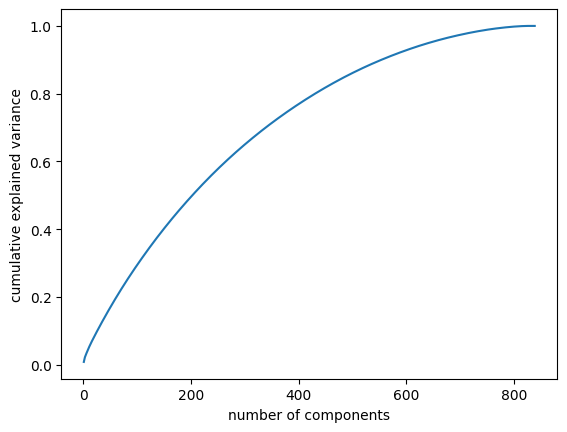

In [146]:
pca = PCA().fit(stand_X_tfidf)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)

#print(f'number of components: {nc}')
#print(f'cumulative explained variance: {ev}')

plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [123]:
# Keep only the first 2 components
pca = PCA(n_components = 2)

# Fit PCA and transform the data in the new coordinates
X_pca = pca.fit_transform(stand_X_tfidf)

# term-document matrix in the new coordinates
X_pca = pd.DataFrame(data = X_pca, columns = ['pc1', 'pc2'])
X_pca

,pc1,pc2
0,-1.769303,-0.558387
1,9.044332,0.702198
2,-3.035786,6.208961
3,-2.545497,-0.880802
4,-1.693746,-5.471970


In [124]:
test_docs

['#domanivotolega',
 'sorpreso dovere essere sincerare commuovere cercare nasconderlo po figliare federico molto riservare me proprio aspettare p s domani votare primo volto dire “ forse ” scegliere legare 🥲 2/2',
 'ieri durare #maratonasalvini live canale social dire dietro quinto “ contributo sorpreso te ” 1/2',
 'intervistare qualche giorno fare ve riproporre #domanivotolega',
 'tre priorità legare guardare video amico domani decidere 7 23 andato votare #domanivotolega 💪']

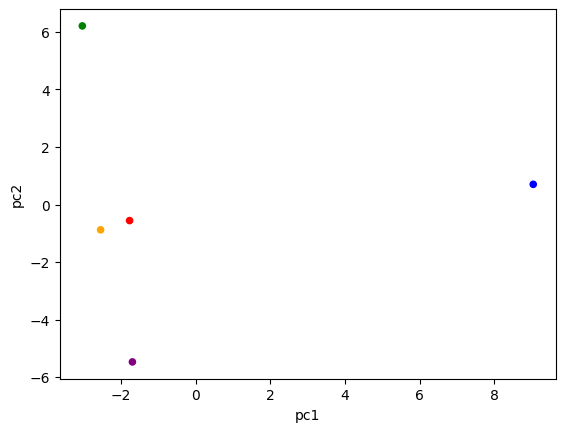

In [33]:
X_pca.plot(kind = 'scatter', x = 'pc1', y = 'pc2', color = ['red','blue','green','orange', 'purple'])
plt.show()

In [ ]:
cleaned_tweet = list()

for tweet in filtered_data["bonino"]:
    cleaned_tweet.append([tweet, tokenize(tweet)])

pd.DataFrame(cleaned_tweet).to_csv("TBD/test.csv")

## IS SPACY USEFUL?

In [79]:
# Punctuation cleaning

nlp = spacy.load("it_core_news_lg")

corpus = dict()
for politician in POLITICIANS:
    corpus[politician] = []
    for tweet in date_filtered_data[politician]:
        for sentence in nlp(tweet).sents:
            # TODO add readibility/ do better
            sentence_text_w_placeholder = re.sub('\+Europa', 'SPECIFICPOLITICALPARTYPLACEHOLDER', sentence.text, flags=re.IGNORECASE)
            cleaned_sentence_text = "".join([x for x in sentence_text_w_placeholder if x not in punctuation and x not in digits])
            corpus[politician].append(re.sub('SPECIFICPOLITICALPARTYPLACEHOLDER', '+Europa', cleaned_sentence_text))

In [97]:
# Tokenization, Lemmatization, StopWords Remover

tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["salvini"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [106]:
Xa.sum().sort_values(ascending=False)

settembrevotolega    197
lega                 181
settembre            148
italiano              96
italia                90
                    ... 
intelligenza           1
insicurezza            1
insetto                1
insegnamento           1
🥲                      1
Length: 1896, dtype: int64


In [107]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["calenda"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
Xa.sum().sort_values(ascending=False)

drago       137
paese       123
italia      106
pd          106
governo     103
           ... 
opinione      1
opificio      1
distanza      1
operaio       1
a             1
Length: 2408, dtype: int64

In [109]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["renzi"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
Xa.sum().sort_values(ascending=False)

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


secondo      17
drago        16
campagna     16
settembre    14
melone       14
             ..
giugno        1
giovedì       1
giovane       1
giorgia       1
♂             1
Length: 542, dtype: int64

In [110]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["conte"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
Xa.sum().sort_values(ascending=False)

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sera          58
intervista    58
movstelle     56
grazie        40
diretta       32
              ..
lisola         2
linteresse     2
linea          2
limpegno       2
📺              2
Length: 672, dtype: int64

In [ ]:
def clean_data(corpus: list):
    # TODO
    return corpus

## Clean data

In [ ]:
out_data = clean_data(input_data)